<a href="https://colab.research.google.com/github/y-lims/DADS7203_ThaiNews_Classification/blob/main/%5B7203%5D_NLP_Final_Project_(MultinomialNB).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

สรุป Flow ของการทำ:

1.   Mount Google Drive และโหลดข้อมูล
2.   ทำ Data Cleaning และ Preprocessing (การลบข้อมูลที่ไม่จำเป็น)
3.   Tokenize ข้อความโดยใช้ PyThaiNLP
4.   แปลงข้อความเป็นเวกเตอร์ (TF-IDF หรือ Word Embeddings)
5.   แบ่งข้อมูลเป็นชุดฝึก (Training) และทดสอบ (Testing)
6.   สร้างและฝึกโมเดล
7.   ทดสอบและประเมินผลโมเดล
8.   ใช้ pre-trained model (ถ้าต้องการ) และประเมินผล

# Install library

In [11]:
pip install pythainlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 50.9 MB/s eta 0:00:00


In [16]:
pip install transformers

In [ ]:
# !pip install pythainlp
# !pip install transformers
# !pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 34.3 MB/s eta 0:00:00


# Load Data

In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
# import pandas as pd

# # ระบุ path ของไฟล์
# file_path = '/content/drive/My Drive/thai_news_title_category.csv'

# # อ่านข้อมูลในรูปแบบ DataFrame
# df = pd.read_csv(file_path)
# df.dropna(inplace=True)
# df.drop_duplicates(inplace=True)

# # แสดงตัวอย่างข้อมูล
# df.head()
# df['category'].value_counts()
# df = df[df['title'].notnull() & df['category'].notnull()]

# # Filter Unneeded class
# df = df[~df['category'].isin(['Unused', 'Royal News'])]

In [17]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive/')

# อ่านไฟล์ CSV
file_path = '/content/drive/My Drive/thai_news_title_category.csv'
df = pd.read_csv(file_path)

# ลบข้อมูลที่เป็น NaN และข้อมูลที่ซ้ำกัน
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# แสดงตัวอย่างข้อมูล
print(df.head())

# ตรวจสอบจำนวนข้อมูลในแต่ละหมวดหมู่
print(df['category'].value_counts())

# กรองข้อมูลที่ไม่ต้องการ
df = df[df['title'].notnull() & df['category'].notnull()]
df = df[~df['category'].isin(['Unused', 'Royal News'])]

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
                labels                                              title  \
0             เศรษฐกิจ  กสทช.เตรียมของบ กทปส. ปฏิรูปวิจัยเรตติ้งทีวีแบ...   
1  บันเทิง,ข่าวบันเทิง  ตั๊ก บริบูรณ์ เล่าถึงวงการหมอนวด เด็กเชียร์แขก...   
2         ข่าว,ทั่วไทย  สมเด็จพระบรมฯ พระราชทานพวงมาลา วางหน้าหีบศพ‘ลุ...   
3       ข่าว,อาชญากรรม  เขยยิงดับแม่ยาย แล้วระเบิดหัวตายตาม! เครียดต่า...   
4         ข่าว,ทั่วไทย  อสส.สอบด่วน อัยการกร่าง ย่ำ 'ศักดิ์ศรี' ตร. (ค...   

             category  
0  Economy & Business  
1       Entertainment  
2     General Affairs  
3     Crime & Justice  
4     General Affairs  
category
General Affairs         93389
Politics                25729
Sports                  24539
Crime & Justice         16184
International News      15702
Economy & Business      13458
Entertainment           13025
Lifestyle & Culture      7981
Technology & 

In [18]:
# ตรวจสอบขนาดขั้นต่ำของแต่ละคลาส
display(df['category'].value_counts())

min_class_size = 1000  # กำหนดจำนวนตัวอย่างที่ต้องการในแต่ละคลาส

# ฟังก์ชันสุ่มตัวอย่างที่ปรับให้เหมาะสมกับคลาสที่มีจำนวนตัวอย่างไม่เพียงพอ
def downsample_group(group, size):
    if len(group) >= size:
        return group.sample(n=size, random_state=42, replace=False)
    else:
        return group  # คืนค่าเดิมหากจำนวนตัวอย่างในคลาสน้อยกว่า size

# ใช้ฟังก์ชันกับการ Down Sampling
df_downsampled = (
    df.groupby('category')
    .apply(lambda x: downsample_group(x, min_class_size))
    .reset_index(drop=True)
)

# ตรวจสอบจำนวนตัวอย่างหลังการ Down Sampling
print("\nจำนวนตัวอย่างหลัง Down Sampling:")
display(df_downsampled['category'].value_counts())

,count
category,
General Affairs,93389
Politics,25729
Sports,24539
Crime & Justice,16184
International News,15702
Economy & Business,13458
Entertainment,13025
Lifestyle & Culture,7981
Technology & Science,7958



จำนวนตัวอย่างหลัง Down Sampling:


<ipython-input-18-8e566041fa1c>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: downsample_group(x, min_class_size))


,count
category,
Crime & Justice,1000
Economy & Business,1000
Entertainment,1000
General Affairs,1000
International News,1000
Lifestyle & Culture,1000
Politics,1000
Sports,1000
Technology & Science,1000


# PyThaiNLP & MultinomialNB

## PyThaiNLP >> TF-IDF >> MultinomialNB (df)

In [28]:
from pythainlp.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# ฟังก์ชั่นการ tokenization ข้อความ
def tokenize_text(text):
    return ' '.join(word_tokenize(text))

# เติมค่า NaN ในคอลัมน์ 'title' ด้วยข้อความว่าง
df_downsampled['title'] = df_downsampled['title'].fillna('')

# Tokenize ข้อความในคอลัมน์ 'title' และเพิ่มคอลัมน์ใน df_downsampled
df_downsampled['tokenized_title'] = df_downsampled['title'].apply(tokenize_text)

# สร้าง TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=1000)

# ฟิตและแปลงข้อความใน df_downsampled
X = tfidf.fit_transform(df_downsampled['tokenized_title']).toarray()

# หมวดหมู่ (label)
y = df_downsampled['category']

Accuracy: 0.59
Precision (Weighted): 0.59
Recall (Weighted): 0.59
F1 Score (Weighted): 0.58
                      precision    recall  f1-score   support

     Crime & Justice       0.56      0.68      0.61       195
  Economy & Business       0.57      0.60      0.59       211
       Entertainment       0.48      0.60      0.54       179
     General Affairs       0.45      0.35      0.39       191
  International News       0.66      0.53      0.59       203
 Lifestyle & Culture       0.55      0.58      0.57       207
            Politics       0.69      0.70      0.69       209
              Sports       0.76      0.81      0.78       204
Technology & Science       0.53      0.40      0.46       201

            accuracy                           0.59      1800
           macro avg       0.58      0.59      0.58      1800
        weighted avg       0.59      0.59      0.58      1800



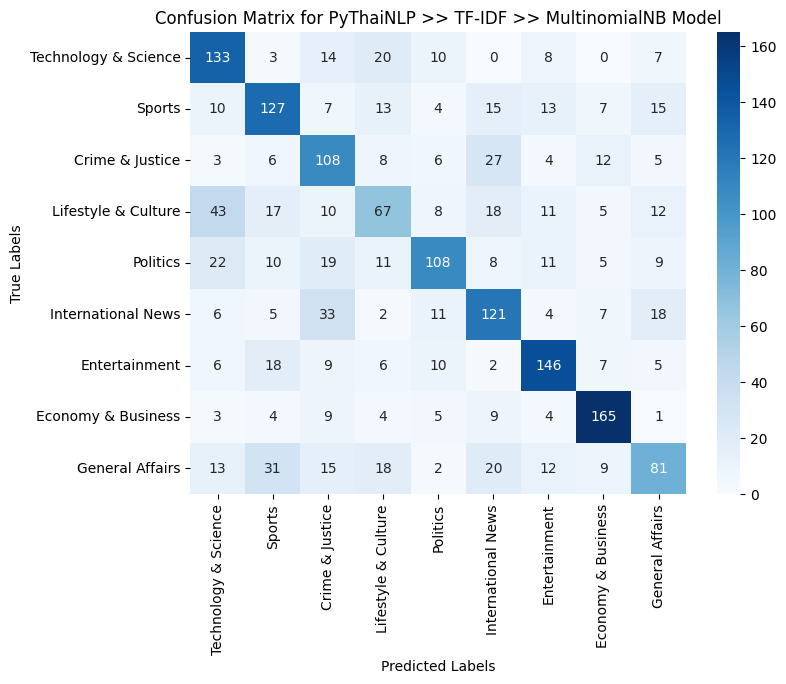

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# แบ่งข้อมูลเป็น training และ testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# สร้างและฝึกโมเดล
model = MultinomialNB()
model.fit(X_train, y_train)

# ทดสอบโมเดล
y_pred = model.predict(X_test)

# **Metrics Calculation**
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Precision (Average='weighted' สำหรับ multiclass)
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision (Weighted): {precision:.2f}")

# Recall (Average='weighted' สำหรับ multiclass)
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall (Weighted): {recall:.2f}")

# F1 Score (Average='weighted' สำหรับ multiclass)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (Weighted): {f1:.2f}")

# แสดง Classification Report
print(classification_report(y_test, y_pred))

# คำนวณ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# แสดง Confusion Matrix เป็น Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for PyThaiNLP >> TF-IDF >> MultinomialNB Model')
plt.show()

## PyThaiNLP >> TF-IDF >> MultinomialNB (df_downsampled)

In [ ]:
# from pythainlp.tokenize import word_tokenize

# # ฟังก์ชั่นการ tokenization ข้อความ
# def tokenize_text(text):
#     return ' '.join(word_tokenize(text))

# # Tokenize ข้อความในคอลัมน์ 'title'
# df_downsampled['tokenized_title'] = df_downsampled['title'].apply(tokenize_text)

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# # สร้าง TF-IDF vectorizer
# tfidf = TfidfVectorizer(max_features=1000)

# # ฟิตและแปลงข้อความ
# X = tfidf.fit_transform(df_downsampled['tokenized_title']).toarray()

# # หมวดหมู่ (label)
# y = df_downsampled['category']

Accuracy: 0.59
Precision (Weighted): 0.59
Recall (Weighted): 0.59
F1 Score (Weighted): 0.58
                      precision    recall  f1-score   support

     Crime & Justice       0.56      0.68      0.61       195
  Economy & Business       0.57      0.60      0.59       211
       Entertainment       0.48      0.60      0.54       179
     General Affairs       0.45      0.35      0.39       191
  International News       0.66      0.53      0.59       203
 Lifestyle & Culture       0.55      0.58      0.57       207
            Politics       0.69      0.70      0.69       209
              Sports       0.76      0.81      0.78       204
Technology & Science       0.53      0.40      0.46       201

            accuracy                           0.59      1800
           macro avg       0.58      0.59      0.58      1800
        weighted avg       0.59      0.59      0.58      1800



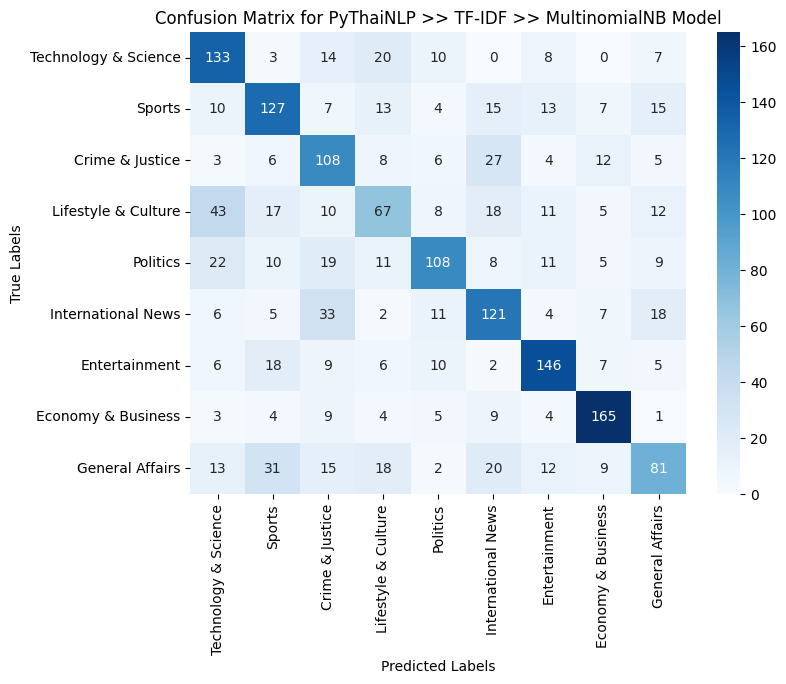

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# แบ่งข้อมูลเป็น training และ testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# สร้างและฝึกโมเดล
model = MultinomialNB()
model.fit(X_train, y_train)

# ทดสอบโมเดล
y_pred = model.predict(X_test)

# **Metrics Calculation**
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Precision (Average='weighted' สำหรับ multiclass)
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision (Weighted): {precision:.2f}")

# Recall (Average='weighted' สำหรับ multiclass)
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall (Weighted): {recall:.2f}")

# F1 Score (Average='weighted' สำหรับ multiclass)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (Weighted): {f1:.2f}")

# แสดง Classification Report
print(classification_report(y_test, y_pred))

# คำนวณ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# แสดง Confusion Matrix เป็น Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for PyThaiNLP >> TF-IDF >> MultinomialNB Model')
plt.show()

## PyThaiNLP >> FastText >> MultinomialNB (df)

In [36]:
pip install fasttext

In [33]:
from pythainlp.tokenize import word_tokenize

# ฟังก์ชั่นการ tokenization ข้อความ
def tokenize_text(text):
    return ' '.join(word_tokenize(text))

# Tokenize ข้อความในคอลัมน์ 'title'
df['tokenized_title'] = df['title'].apply(tokenize_text)

### skipgram

In [55]:
import fasttext

# บันทึกข้อความที่ถูก tokenized ลงในไฟล์ (ข้อความหนึ่งบรรทัดต่อหนึ่งตัวอย่าง)
with open("train.txt", "w", encoding="utf-8") as f:
    for text in df['tokenized_title']:
        f.write(f"__label__ {text}\n")  # บันทึกข้อความในรูปแบบ label-text (คุณสามารถใช้ __label__ ได้หากต้องการจัดประเภท)

# ฝึก FastText model
model = fasttext.train_unsupervised('train.txt', model='skipgram')  # ใช้ skipgram หรือ cbow ตามที่ต้องการ

In [56]:
import numpy as np
from pythainlp.tokenize import word_tokenize

# ใช้ FastText model ในการแปลงข้อความให้เป็นเวกเตอร์
def get_fasttext_vector(text):
    tokens = word_tokenize(text)  # ใช้ pythainlp tokenizer
    vectors = [model.get_word_vector(token) for token in tokens if token in model]  # คำนวณเวกเตอร์ของแต่ละคำ
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.dim)  # ค่าเฉลี่ยของเวกเตอร์คำ หรือ 0 ถ้าไม่มีคำ

# แปลงข้อความในคอลัมน์ 'title' เป็นเวกเตอร์
X_fasttext = np.array([get_fasttext_vector(text) for text in df['title']])

In [57]:
import numpy as np

# ใช้ FastText model ในการแปลงข้อความให้เป็นเวกเตอร์
def get_fasttext_vector(text):
    tokens = word_tokenize(text)  # ใช้ pythainlp tokenizer
    vectors = [model.get_word_vector(token) for token in tokens if token in model]  # คำนวณเวกเตอร์ของแต่ละคำ
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.dim)  # ค่าเฉลี่ยของเวกเตอร์คำ หรือ 0 ถ้าไม่มีคำ

# แปลงข้อความในคอลัมน์ 'title' เป็นเวกเตอร์
X_fasttext = np.array([get_fasttext_vector(text) for text in df['title']])

In [ ]:
# แปลง labels (y) ให้เป็นตัวเลข
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['category'])

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# ปรับค่าทุกค่าที่เป็นลบใน X_fasttext ให้อยู่ในช่วงบวก
X_fasttext = np.abs(X_fasttext)

# แบ่งข้อมูลเป็น training และ testing set
X_train, X_test, y_train, y_test = train_test_split(X_fasttext, y_encoded, test_size=0.2, random_state=42)

# สร้างและฝึกโมเดล
model = MultinomialNB()
model.fit(X_train, y_train)

# ทดสอบโมเดล
y_pred = model.predict(X_test)

# **Metrics Calculation**
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision (Weighted): {precision:.2f}")

recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall (Weighted): {recall:.2f}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (Weighted): {f1:.2f}")

# แสดง Classification Report
print(classification_report(y_test, y_pred))

# คำนวณ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# แสดง Confusion Matrix เป็น Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for PyThaiNLP >> FastText >> MultinomialNB Model')
plt.show()

In [ ]:
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# ปรับค่าทุกค่าที่เป็นลบใน X_fasttext ให้อยู่ในช่วงบวก
X_fasttext = np.abs(X_fasttext)

# แบ่งข้อมูลเป็น training และ testing set
X_train, X_test, y_train, y_test = train_test_split(X_fasttext, y_encoded, test_size=0.2, random_state=42)

# **Measure Training Time**
start_time = time.time()

# สร้างและฝึกโมเดล
model = MultinomialNB()
model.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time
print(f"Model Training Time: {training_time:.2f} seconds")

# ทดสอบโมเดล
y_pred = model.predict(X_test)

# **Metrics Calculation**
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision (Weighted): {precision:.2f}")

recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall (Weighted): {recall:.2f}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (Weighted): {f1:.2f}")

# แสดง Classification Report
print(classification_report(y_test, y_pred))

# คำนวณ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# แสดง Confusion Matrix เป็น Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for PyThaiNLP >> FastText >> MultinomialNB Model')
plt.show()

### cbow

In [ ]:
import fasttext

# บันทึกข้อความที่ถูก tokenized ลงในไฟล์ (ข้อความหนึ่งบรรทัดต่อหนึ่งตัวอย่าง)
with open("train.txt", "w", encoding="utf-8") as f:
    for text in df['tokenized_title']:
        f.write(f"__label__ {text}\n")  # บันทึกข้อความในรูปแบบ label-text (คุณสามารถใช้ __label__ ได้หากต้องการจัดประเภท)

# ฝึก FastText model
model = fasttext.train_unsupervised('train.txt', model='cbow')  # ใช้ skipgram หรือ cbow ตามที่ต้องการ

In [ ]:
import numpy as np

# ใช้ FastText model ในการแปลงข้อความให้เป็นเวกเตอร์
def get_fasttext_vector(text):
    tokens = word_tokenize(text)  # ใช้ pythainlp tokenizer
    vectors = [model.get_word_vector(token) for token in tokens if token in model]  # คำนวณเวกเตอร์ของแต่ละคำ
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.dim)  # ค่าเฉลี่ยของเวกเตอร์คำ หรือ 0 ถ้าไม่มีคำ

# แปลงข้อความในคอลัมน์ 'title' เป็นเวกเตอร์
X_fasttext = np.array([get_fasttext_vector(text) for text in df['title']])

In [ ]:
# แปลง labels (y) ให้เป็นตัวเลข
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['category'])

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# ปรับค่าทุกค่าที่เป็นลบใน X_fasttext ให้อยู่ในช่วงบวก
X_fasttext = np.abs(X_fasttext)

# แบ่งข้อมูลเป็น training และ testing set
X_train, X_test, y_train, y_test = train_test_split(X_fasttext, y_encoded, test_size=0.2, random_state=42)

# สร้างและฝึกโมเดล
model = MultinomialNB()
model.fit(X_train, y_train)

# ทดสอบโมเดล
y_pred = model.predict(X_test)

# **Metrics Calculation**
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision (Weighted): {precision:.2f}")

recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall (Weighted): {recall:.2f}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (Weighted): {f1:.2f}")

# แสดง Classification Report
print(classification_report(y_test, y_pred))

# คำนวณ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# แสดง Confusion Matrix เป็น Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for PyThaiNLP >> FastText >> MultinomialNB Model')
plt.show()

## PyThaiNLP >> FastText >> MultinomialNB (df_downsampled)

### skipgram

In [50]:
import fasttext

# บันทึกข้อความที่ถูก tokenized ลงในไฟล์ (ข้อความหนึ่งบรรทัดต่อหนึ่งตัวอย่าง)
with open("train.txt", "w", encoding="utf-8") as f:
    for text in df_downsampled['tokenized_title']:
        f.write(f"__label__ {text}\n")  # บันทึกข้อความในรูปแบบ label-text (คุณสามารถใช้ __label__ ได้หากต้องการจัดประเภท)

# ฝึก FastText model
model = fasttext.train_unsupervised('train.txt', model='skipgram')  # ใช้ skipgram หรือ cbow ตามที่ต้องการ

In [51]:
import numpy as np

# ใช้ FastText model ในการแปลงข้อความให้เป็นเวกเตอร์
def get_fasttext_vector(text):
    tokens = word_tokenize(text)  # ใช้ pythainlp tokenizer
    vectors = [model.get_word_vector(token) for token in tokens if token in model]  # คำนวณเวกเตอร์ของแต่ละคำ
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.dim)  # ค่าเฉลี่ยของเวกเตอร์คำ หรือ 0 ถ้าไม่มีคำ

# แปลงข้อความในคอลัมน์ 'title' เป็นเวกเตอร์
X_fasttext = np.array([get_fasttext_vector(text) for text in df_downsampled['title']])

In [52]:
# แปลง labels (y) ให้เป็นตัวเลข
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_downsampled['category'])

Model Training Time: 0.03 seconds
Accuracy: 0.14
Precision (Weighted): 0.29
Recall (Weighted): 0.14
F1 Score (Weighted): 0.07
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       195
           1       1.00      0.00      0.01       211
           2       0.12      0.97      0.21       179
           3       0.19      0.18      0.18       191
           4       0.00      0.00      0.00       203
           5       0.00      0.00      0.00       207
           6       0.32      0.22      0.26       209
           7       0.00      0.00      0.00       204
           8       0.00      0.00      0.00       201

    accuracy                           0.14      1800
   macro avg       0.29      0.15      0.08      1800
weighted avg       0.29      0.14      0.07      1800



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

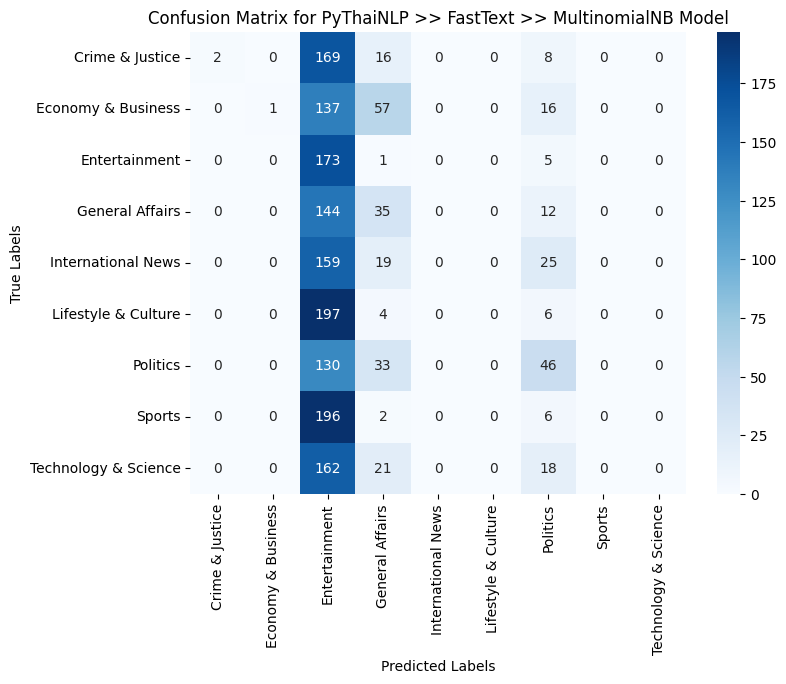

In [54]:
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# ปรับค่าทุกค่าที่เป็นลบใน X_fasttext ให้อยู่ในช่วงบวก
X_fasttext = np.abs(X_fasttext)

# แบ่งข้อมูลเป็น training และ testing set
X_train, X_test, y_train, y_test = train_test_split(X_fasttext, y_encoded, test_size=0.2, random_state=42)

# **Measure Training Time**
start_time = time.time()

# สร้างและฝึกโมเดล
model = MultinomialNB()
model.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time
print(f"Model Training Time: {training_time:.2f} seconds")

# ทดสอบโมเดล
y_pred = model.predict(X_test)

# **Metrics Calculation**
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision (Weighted): {precision:.2f}")

recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall (Weighted): {recall:.2f}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (Weighted): {f1:.2f}")

# แสดง Classification Report
print(classification_report(y_test, y_pred))

# คำนวณ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# แสดง Confusion Matrix เป็น Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for PyThaiNLP >> FastText >> MultinomialNB Model')
plt.show()

### cbow

In [ ]:
import fasttext

# บันทึกข้อความที่ถูก tokenized ลงในไฟล์ (ข้อความหนึ่งบรรทัดต่อหนึ่งตัวอย่าง)
with open("train.txt", "w", encoding="utf-8") as f:
    for text in df_downsampled['tokenized_title']:
        f.write(f"__label__ {text}\n")  # บันทึกข้อความในรูปแบบ label-text (คุณสามารถใช้ __label__ ได้หากต้องการจัดประเภท)

# ฝึก FastText model
model = fasttext.train_unsupervised('train.txt', model='cbow')  # ใช้ skipgram หรือ cbow ตามที่ต้องการ

In [ ]:
import numpy as np

# ใช้ FastText model ในการแปลงข้อความให้เป็นเวกเตอร์
def get_fasttext_vector(text):
    tokens = word_tokenize(text)  # ใช้ pythainlp tokenizer
    vectors = [model.get_word_vector(token) for token in tokens if token in model]  # คำนวณเวกเตอร์ของแต่ละคำ
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.dim)  # ค่าเฉลี่ยของเวกเตอร์คำ หรือ 0 ถ้าไม่มีคำ

# แปลงข้อความในคอลัมน์ 'title' เป็นเวกเตอร์
X_fasttext = np.array([get_fasttext_vector(text) for text in df_downsampled['title']])

In [ ]:
# แปลง labels (y) ให้เป็นตัวเลข
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_downsampled['category'])

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# ปรับค่าทุกค่าที่เป็นลบใน X_fasttext ให้อยู่ในช่วงบวก
X_fasttext = np.abs(X_fasttext)

# แบ่งข้อมูลเป็น training และ testing set
X_train, X_test, y_train, y_test = train_test_split(X_fasttext, y_encoded, test_size=0.2, random_state=42)

# สร้างและฝึกโมเดล
model = MultinomialNB()
model.fit(X_train, y_train)

# ทดสอบโมเดล
y_pred = model.predict(X_test)

# **Metrics Calculation**
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision (Weighted): {precision:.2f}")

recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall (Weighted): {recall:.2f}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (Weighted): {f1:.2f}")

# แสดง Classification Report
print(classification_report(y_test, y_pred))

# คำนวณ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# แสดง Confusion Matrix เป็น Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for PyThaiNLP >> FastText >> MultinomialNB Model')
plt.show()

# PyThaiNLP & XGBoost

## PyThaiNLP >> TF-IDF >> XGBoost (df)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:13:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.65
Precision (Weighted): 0.67
Recall (Weighted): 0.65
F1 Score (Weighted): 0.62
                      precision    recall  f1-score   support

     Crime & Justice       0.55      0.24      0.33      3249
  Economy & Business       0.66      0.37      0.48      2714
       Entertainment       0.71      0.30      0.43      2614
     General Affairs       0.59      0.91      0.71     18689
  International News       0.76      0.42      0.54      3091
 Lifestyle & Culture       0.68      0.26      0.37      1615
            Politics       0.79      0.61      0.69      5250
              Sports       0.87      0.75      0.81      4774
Technology & Science       0.67      0.12      0.21      1597

            accuracy                           0.65     43593
           macro avg       0.70      0.44      0.51     43593
        weighted avg       0.67      0.65      0.62     43593



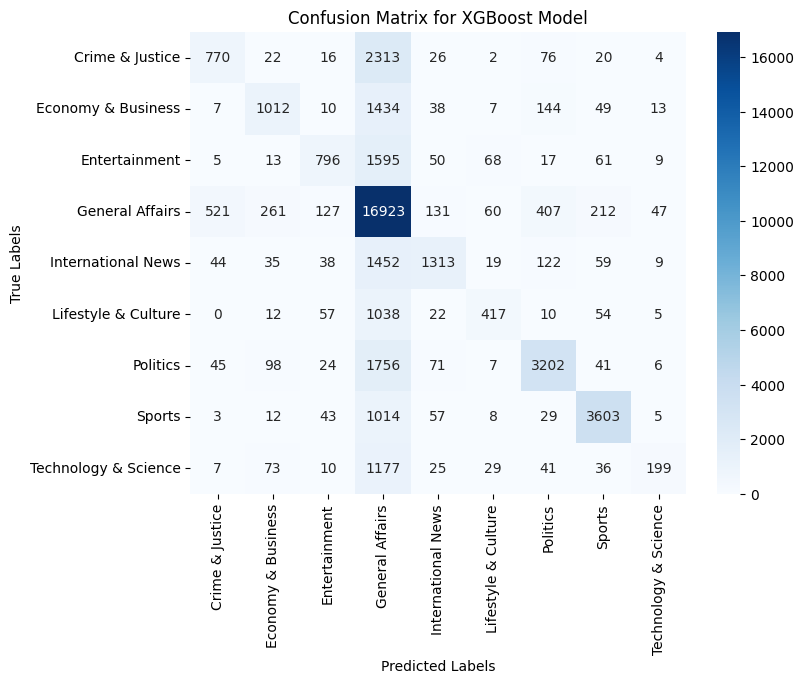

In [46]:
from pythainlp.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# 1. ฟังก์ชั่น Tokenization
def tokenize_text(text):
    return ' '.join(word_tokenize(text))

# 2. Tokenize ข้อความในคอลัมน์ 'title'
df['tokenized_title'] = df['title'].apply(tokenize_text)

# 3. สร้าง TF-IDF vectorizer และแปลงข้อมูลข้อความเป็นเวกเตอร์
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df['tokenized_title']).toarray()

# 4. ใช้ LabelEncoder แปลง labels (หมวดหมู่) เป็นตัวเลข
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['category'])

# 5. แบ่งข้อมูลเป็น training และ testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. สร้างและฝึกโมเดล XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# 7. ทำนายผล
y_pred = model.predict(X_test)

# **Metrics Calculation**
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Precision (Average='weighted' สำหรับ multiclass)
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision (Weighted): {precision:.2f}")

# Recall (Average='weighted' สำหรับ multiclass)
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall (Weighted): {recall:.2f}")

# F1 Score (Average='weighted' สำหรับ multiclass)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (Weighted): {f1:.2f}")

# แสดง Classification Report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# คำนวณ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# แสดง Confusion Matrix เป็น Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for XGBoost Model')
plt.show()

## PyThaiNLP >> TF-IDF >> XGBoost (df_downsampled)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:36:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Training Time: 24.60 seconds
Accuracy: 0.53
Precision (Weighted): 0.53
Recall (Weighted): 0.53
F1 Score (Weighted): 0.53
                      precision    recall  f1-score   support

     Crime & Justice       0.59      0.57      0.58       195
  Economy & Business       0.53      0.54      0.53       211
       Entertainment       0.45      0.47      0.46       179
     General Affairs       0.32      0.31      0.31       191
  International News       0.58      0.52      0.55       203
 Lifestyle & Culture       0.48      0.54      0.51       207
            Politics       0.65      0.65      0.65       209
              Sports       0.73      0.75      0.74       204
Technology & Science       0.43      0.41      0.42       201

            accuracy                           0.53      1800
           macro avg       0.53      0.53      0.53      1800
        weighted avg       0.53      0.53      0.53      1800



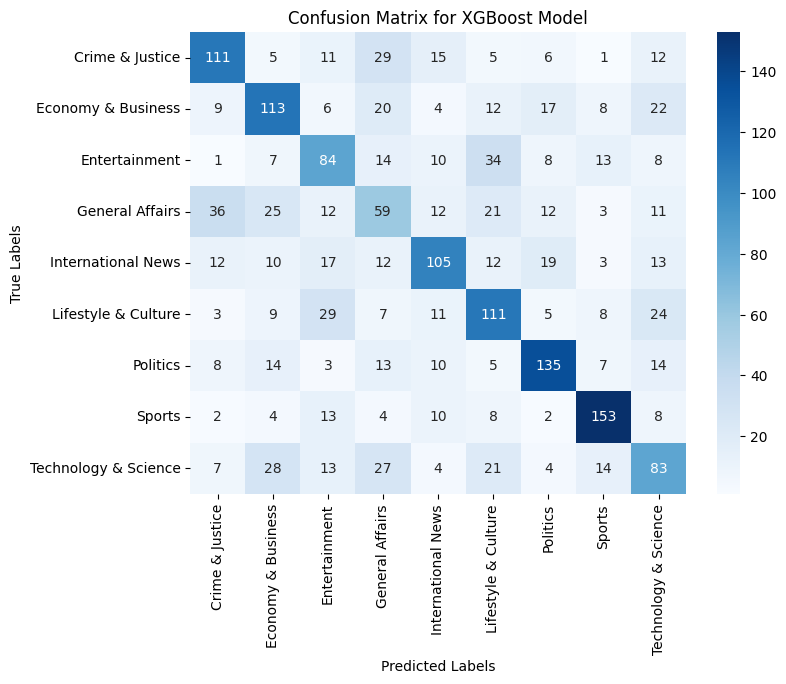

In [49]:
import time  # Import time module
from pythainlp.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# 1. ฟังก์ชั่น Tokenization
def tokenize_text(text):
    return ' '.join(word_tokenize(text))

# 2. Tokenize ข้อความในคอลัมน์ 'title'
df_downsampled['tokenized_title'] = df_downsampled['title'].apply(tokenize_text)

# 3. สร้าง TF-IDF vectorizer และแปลงข้อมูลข้อความเป็นเวกเตอร์
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df_downsampled['tokenized_title']).toarray()

# 4. ใช้ LabelEncoder แปลง labels (หมวดหมู่) เป็นตัวเลข
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_downsampled['category'])

# 5. แบ่งข้อมูลเป็น training และ testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. สร้างและฝึกโมเดล XGBoost พร้อมจับเวลา
start_train_time = time.time()  # Start timing
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)
end_train_time = time.time()  # End timing

# คำนวณเวลาในการฝึกโมเดล
training_time = end_train_time - start_train_time
print(f"Model Training Time: {training_time:.2f} seconds")

# 7. ทำนายผล
y_pred = model.predict(X_test)

# **Metrics Calculation**
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Precision (Average='weighted' สำหรับ multiclass)
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision (Weighted): {precision:.2f}")

# Recall (Average='weighted' สำหรับ multiclass)
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall (Weighted): {recall:.2f}")

# F1 Score (Average='weighted' สำหรับ multiclass)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (Weighted): {f1:.2f}")

# แสดง Classification Report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# คำนวณ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# แสดง Confusion Matrix เป็น Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for XGBoost Model')
plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:22:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.53
Precision (Weighted): 0.53
Recall (Weighted): 0.53
F1 Score (Weighted): 0.53
                      precision    recall  f1-score   support

     Crime & Justice       0.59      0.57      0.58       195
  Economy & Business       0.53      0.54      0.53       211
       Entertainment       0.45      0.47      0.46       179
     General Affairs       0.32      0.31      0.31       191
  International News       0.58      0.52      0.55       203
 Lifestyle & Culture       0.48      0.54      0.51       207
            Politics       0.65      0.65      0.65       209
              Sports       0.73      0.75      0.74       204
Technology & Science       0.43      0.41      0.42       201

            accuracy                           0.53      1800
           macro avg       0.53      0.53      0.53      1800
        weighted avg       0.53      0.53      0.53      1800



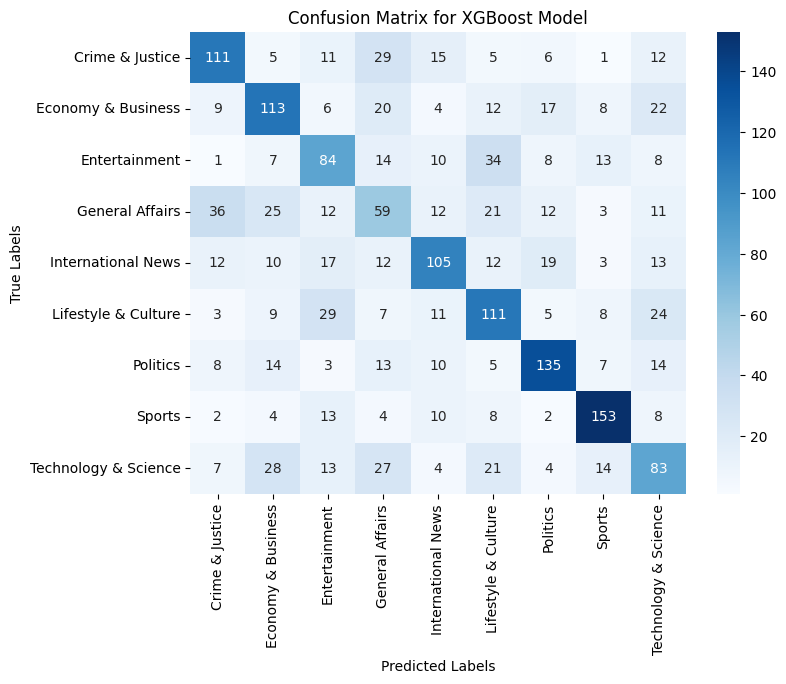

In [47]:
from pythainlp.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# 1. ฟังก์ชั่น Tokenization
def tokenize_text(text):
    return ' '.join(word_tokenize(text))

# 2. Tokenize ข้อความในคอลัมน์ 'title'
df_downsampled['tokenized_title'] = df_downsampled['title'].apply(tokenize_text)

# 3. สร้าง TF-IDF vectorizer และแปลงข้อมูลข้อความเป็นเวกเตอร์
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df_downsampled['tokenized_title']).toarray()

# 4. ใช้ LabelEncoder แปลง labels (หมวดหมู่) เป็นตัวเลข
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_downsampled['category'])

# 5. แบ่งข้อมูลเป็น training และ testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. สร้างและฝึกโมเดล XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# 7. ทำนายผล
y_pred = model.predict(X_test)

# **Metrics Calculation**
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Precision (Average='weighted' สำหรับ multiclass)
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision (Weighted): {precision:.2f}")

# Recall (Average='weighted' สำหรับ multiclass)
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall (Weighted): {recall:.2f}")

# F1 Score (Average='weighted' สำหรับ multiclass)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (Weighted): {f1:.2f}")

# แสดง Classification Report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# คำนวณ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# แสดง Confusion Matrix เป็น Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for XGBoost Model')
plt.show()

## PyThaiNLP >> FastText >> XGBoost (df_downsampled)

In [ ]:
pip install fasttext

In [42]:
import fasttext

# บันทึกข้อความที่ถูก tokenized ลงในไฟล์ (ข้อความหนึ่งบรรทัดต่อหนึ่งตัวอย่าง)
with open("train.txt", "w", encoding="utf-8") as f:
    for text in df_downsampled['tokenized_title']:
        f.write(f"__label__ {text}\n")  # บันทึกข้อความในรูปแบบ label-text (คุณสามารถใช้ __label__ ได้หากต้องการจัดประเภท)

# ฝึก FastText model
model = fasttext.train_unsupervised('train.txt', model='skipgram')  # ใช้ skipgram หรือ cbow ตามที่ต้องการ

In [43]:
import numpy as np

# ใช้ FastText model ในการแปลงข้อความให้เป็นเวกเตอร์
def get_fasttext_vector(text):
    tokens = word_tokenize(text)  # ใช้ pythainlp tokenizer
    vectors = [model.get_word_vector(token) for token in tokens if token in model]  # คำนวณเวกเตอร์ของแต่ละคำ
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.dim)  # ค่าเฉลี่ยของเวกเตอร์คำ หรือ 0 ถ้าไม่มีคำ

# แปลงข้อความในคอลัมน์ 'title' เป็นเวกเตอร์
X_fasttext = np.array([get_fasttext_vector(text) for text in df_downsampled['title']])

In [44]:
# แปลง labels (y) ให้เป็นตัวเลข
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_downsampled['category'])

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:23:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Training Time: 28.29 seconds
Model Prediction Time: 0.04 seconds
Accuracy: 0.48
Precision (Weighted): 0.48
Recall (Weighted): 0.48
F1 Score (Weighted): 0.48
              precision    recall  f1-score   support

           0       0.55      0.59      0.57       195
           1       0.51      0.55      0.53       211
           2       0.43      0.51      0.47       179
           3       0.29      0.24      0.26       191
           4       0.40      0.32      0.36       203
           5       0.46      0.47      0.47       207
           6       0.51      0.57      0.54       209
           7       0.73      0.73      0.73       204
           8       0.38      0.35      0.36       201

    accuracy                           0.48      1800
   macro avg       0.47      0.48      0.48      1800
weighted avg       0.48      0.48      0.48      1800



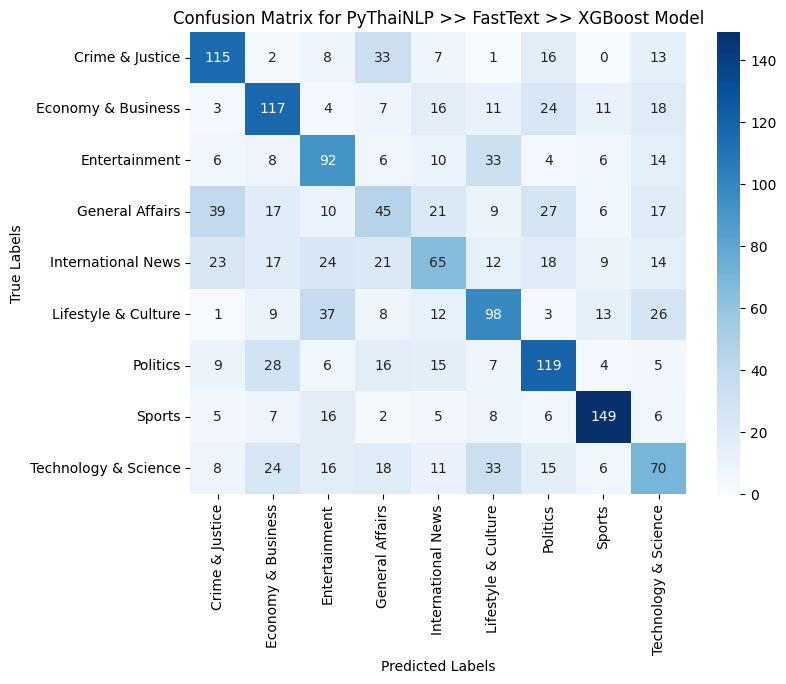

In [48]:
import time
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# ปรับค่าทุกค่าที่เป็นลบใน X_fasttext ให้อยู่ในช่วงบวก
X_fasttext = np.abs(X_fasttext)

# แบ่งข้อมูลเป็น training และ testing set
X_train, X_test, y_train, y_test = train_test_split(X_fasttext, y_encoded, test_size=0.2, random_state=42)

# **Measure Training Time**
start_train_time = time.time()

# สร้างและฝึกโมเดล XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X_train, y_train)

end_train_time = time.time()
training_time = end_train_time - start_train_time
print(f"Model Training Time: {training_time:.2f} seconds")

# **Measure Prediction Time**
start_pred_time = time.time()

# ทดสอบโมเดล
y_pred = model.predict(X_test)

end_pred_time = time.time()
prediction_time = end_pred_time - start_pred_time
print(f"Model Prediction Time: {prediction_time:.2f} seconds")

# **Metrics Calculation**
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision (Weighted): {precision:.2f}")

recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall (Weighted): {recall:.2f}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (Weighted): {f1:.2f}")

# แสดง Classification Report
print(classification_report(y_test, y_pred))

# คำนวณ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# แสดง Confusion Matrix เป็น Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for PyThaiNLP >> FastText >> XGBoost Model')
plt.show()

# BERT Tokenizer

In [ ]:
# from transformers import BertTokenizer, BertForSequenceClassification
# import torch
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from torch.utils.data import DataLoader, TensorDataset

# # ตรวจสอบว่า GPU (CUDA) พร้อมใช้งานหรือไม่
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # โหลด pre-trained BERT model และ tokenizer สำหรับภาษาไทย
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
# model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(df['category'].unique()))

# # ย้ายโมเดลไปที่ device (GPU หรือ CPU)
# model.to(device)

# # Tokenize ข้อความ
# inputs = tokenizer(df['tokenized_title'].tolist(), padding=True, truncation=True, return_tensors='pt')

# # แยกข้อมูล input_ids และ attention_mask ออกจาก inputs
# input_ids = inputs['input_ids']
# attention_mask = inputs['attention_mask']

# # แปลง labels (y) ให้เป็นตัวเลขด้วย LabelEncoder
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(df['category'])

# # แบ่งข้อมูลเป็น training และ testing set
# X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(input_ids, attention_mask, y_encoded, test_size=0.2, random_state=42)

# # แปลงข้อมูลทั้งหมดเป็น torch tensors
# X_train_ids = torch.tensor(X_train_ids)
# X_test_ids = torch.tensor(X_test_ids)
# X_train_mask = torch.tensor(X_train_mask)
# X_test_mask = torch.tensor(X_test_mask)
# y_train = torch.tensor(y_train, dtype=torch.long)
# y_test = torch.tensor(y_test, dtype=torch.long)

# # เตรียมข้อมูล train และ test สำหรับ BERT model
# train_data = TensorDataset(X_train_ids, X_train_mask, y_train)
# test_data = TensorDataset(X_test_ids, X_test_mask, y_test)

# # สร้าง DataLoader สำหรับ training และ testing
# train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=16)

# # ฝึกโมเดล
# model.train()
# for batch in train_dataloader:
#     b_input_ids, b_input_mask, b_labels = batch

#     # ย้ายข้อมูลไปที่ device (GPU หรือ CPU)
#     b_input_ids = b_input_ids.to(device)
#     b_input_mask = b_input_mask.to(device)
#     b_labels = b_labels.to(device)

#     # Forward pass
#     outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
#     loss = outputs.loss

#     # แสดงค่า loss สำหรับแต่ละ batch
#     print(loss.item())

In [ ]:
# import torch
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# # Set the model to evaluation mode
# model.eval()
# predictions = []
# true_labels = []

# # Loop through the test set to make predictions
# with torch.no_grad():  # No gradient calculation is needed during evaluation
#     for batch in test_dataloader:
#         b_input_ids, b_input_mask, b_labels = batch

#         # Move data to the correct device (GPU or CPU)
#         b_input_ids = b_input_ids.to(device)
#         b_input_mask = b_input_mask.to(device)
#         b_labels = b_labels.to(device)

#         # Forward pass (no labels, only input_ids and attention_mask)
#         outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
#         logits = outputs.logits

#         # Get predictions (index of the highest logit value)
#         predicted_labels = torch.argmax(logits, dim=1)

#         # Store predictions and true labels
#         predictions.extend(predicted_labels.cpu().numpy())  # Convert to CPU and then numpy
#         true_labels.extend(b_labels.cpu().numpy())

# # Display predictions and true labels
# print("Predictions:", predictions)
# print("True Labels:", true_labels)

# # Classification report
# print(classification_report(true_labels, predictions, target_names=label_encoder.classes_))

# # Metrics Calculation (using predictions and true_labels)
# accuracy = accuracy_score(true_labels, predictions)
# print(f"Accuracy: {accuracy:.2f}")

# precision = precision_score(true_labels, predictions, average='weighted')
# print(f"Precision (Weighted): {precision:.2f}")

# recall = recall_score(true_labels, predictions, average='weighted')
# print(f"Recall (Weighted): {recall:.2f}")

# f1 = f1_score(true_labels, predictions, average='weighted')
# print(f"F1 Score (Weighted): {f1:.2f}")

# # Confusion Matrix
# conf_matrix = confusion_matrix(true_labels, predictions)

# # Display Confusion Matrix as Heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix for BERT Model')
# plt.show()